# Libs and scripts import

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor, BaggingRegressor
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV


from sklearn.datasets import make_regression

import seaborn as sns
%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 12})

In [3]:
# ограничение на количество выводимых рядов
pd.set_option('display.max_rows', 10)
# ограничение на число столбцов
#pd.set_option('display.max_columns', None)
# ограничение на количество символов в записи
#pd.set_option('display.max_colwidth', None)

In [18]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [17]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,WrongDistr,WrongSquare,WrongHouseYear,WrongHouseFloor
0,11809,27,3.0,115.0,NaN,10.0,4.0,10.0,2014.0,0.075424,...,0,NaN,0,0,B,305019.0,0.0,0.0,0.0,0.0
1,3013,22,1.0,40.0,23.17,8.0,7.0,8.0,1966.0,0.118537,...,1,1183.0,1,0,B,177735.0,0.0,0.0,0.0,0.0
2,8215,1,3.0,78.0,47.67,10.0,2.0,17.0,NaN,0.025609,...,0,240.0,3,1,B,282079.0,0.0,0.0,1.0,0.0
3,2352,1,1.0,40.0,NaN,1.0,10.0,22.0,NaN,0.007122,...,0,NaN,0,1,B,168106.0,0.0,0.0,1.0,0.0
4,13866,94,2.0,64.0,38.56,9.0,16.0,16.0,NaN,0.282798,...,2,NaN,0,6,B,343995.0,0.0,0.0,1.0,0.0


In [6]:
print('Strings in train:', train.shape[0])
print('Strings in test:', test.shape[0])

Strings in train: 10000
Strings in test: 5000


In [7]:
train.shape[1] - 1 == test.shape[1]

True

# 1. Exploratory Data Analysis. Data validation

min, max, median, etc.

In [8]:
temp = train.loc[(train['HouseYear'] > 0)]
for item in temp.columns:
    if train[item].dtype in ['int64', 'float64']:
        item_mean = temp[item].mean()
        item_mode = temp[item].mode()[0]
        item_median = temp[item].median()
    else: 
        item_mean = None
        item_mode = None
        item_median = None
    print(item, 'Min value: ', temp[item].min(), '\n',
          'Mean value: ', item_mean, '\n',
          'Mode value: ', item_mode, '\n',
          'Median value: ', item_median, '\n',
          'Max value: ', temp[item].max(),  '\n',
           np.unique,  '\n', '\n')


Id Min value:  0 
 Mean value:  8383.4077 
 Mode value:  0 
 Median value:  8394.5 
 Max value:  16798 
 <function unique at 0x7ffd686fd550> 
 

DistrictId Min value:  0 
 Mean value:  50.4008 
 Mode value:  27 
 Median value:  36.0 
 Max value:  209 
 <function unique at 0x7ffd686fd550> 
 

Rooms Min value:  0.0 
 Mean value:  1.8905 
 Mode value:  2.0 
 Median value:  2.0 
 Max value:  19.0 
 <function unique at 0x7ffd686fd550> 
 

Square Min value:  1.1368587776514651 
 Mean value:  56.315775197935615 
 Mode value:  1.1368587776514651 
 Median value:  52.51330992401352 
 Max value:  641.0651927456407 
 <function unique at 0x7ffd686fd550> 
 

LifeSquare Min value:  0.37061941947669375 
 Mean value:  37.199644827673275 
 Mode value:  0.37061941947669375 
 Median value:  32.78126019215573 
 Max value:  7480.592128925201 
 <function unique at 0x7ffd686fd550> 
 

KitchenSquare Min value:  0.0 
 Mean value:  6.2733 
 Mode value:  1.0 
 Median value:  6.0 
 Max value:  2014.0 
 <function u

In [9]:
train.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Some rounding and data correction

In [19]:
# round flat area
train['Square'] = train['Square'].round(2)
# round LifeSquare
train['LifeSquare'] = train['LifeSquare'].round(2)
# round KitchenSquare
train['KitchenSquare'] = train['KitchenSquare'].round(2)
# round Price
train['Price'] = train['Price'].round(0)
print(train.dtypes)

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object


In [11]:
class DataPreprocessing:
    """Correction of the possible wrong data"""
    def __init__(self):
        self.av_X = pd.DataFrame()
    
    def district_corr(self, X):
        wrongDataIdx = (X['DistrictId'] >= 200)
        X.loc[wrongDataIdx, 'WrongDistr'] = 1
        X.loc[wrongDataIdx, 'DistrictId'] = X.loc[wrongDataIdx, 'DistrictId'] - 100

        wrongDataIdx = (X['DistrictId'] == 0)
        X.loc[wrongDataIdx, 'WrongDistr'] = 1
        X.loc[wrongDataIdx, 'DistrictId'] = 9
        
        wrongDataIdx = (X['DistrictId'] >= 147)
        X.loc[wrongDataIdx, 'WrongDistr'] = 1
        X.loc[wrongDataIdx, 'DistrictId'] = X.loc[wrongDataIdx, 'DistrictId'] - 100
        
        """for houseyearstep in range(1902,2020,2):
            wrongDataIdx = ((X['HouseYear'] >= houseyearstep - 5) & (X['HouseYear'] < houseyearstep))
            temp = X.loc[wrongDataIdx].groupby(['DistrictId', 'HouseYear'])['HouseFloor'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'HouseFloor':'MedianDistrHouseFloor'})
        X = X.merge(temp, on = ['DistrictId', 'HouseYear'], how = 'left')
        a = min(X['DistrictId'])
        b = max(X['DistrictId']) + 1
        for ind in range(a,b):
            wrongDataIdx = (X['DistrictId'] == ind) & ((abs(1 - (X['HouseFloor'] / X['MedianDistrHouseFloor']))) > 0.5)
            corrDataIdx = (X['DistrictId'] == ind) & ((abs(1 - (X['HouseFloor'] / X['MedianDistrHouseFloor']))) < 0.5)
            X.loc[wrongDataIdx, 'WrongDistr'] = 1
            X.loc[wrongDataIdx, 'DistrictId'] = X.loc[corrDataIdx, 'DistrictId'].median()
        X = X.drop(columns = ['MedianDistrHouseFloor'])"""
        X.loc[(X['WrongDistr'].isnull()), 'WrongDistr'] = 0
        return X
    
    def square_correction(self, X):
        wrongDataIdx = (X['Square'] <= 5)
        X.loc[wrongDataIdx, 'WrongSquare'] = 1
        X.loc[wrongDataIdx, ['Square']] = X.loc[wrongDataIdx, ['Square']] * 10
        
        wrongDataIdx = (X['Square'] >= 150) & (X['Square'] <= 180) & (X['Rooms'] >= 2) & (X['Rooms'] <= 4) & (X['HouseYear'] < 1990)
        X.loc[wrongDataIdx, 'WrongSquare'] = 1
        X.loc[wrongDataIdx, ['Square']] = X.loc[wrongDataIdx, ['Square']] % 100
        
        wrongDataIdx = ((X['Square'] >= 150) & (X['Square'] <= 170) & (X['Rooms'] < 5) & (X['Rooms'] > 1) & (X['Floor'] < 17) & (X['HouseFloor'] < 17) & (X['HouseYear'] <= 1994))
        corrDataIdx = ((X['Square'] >= 150) & (X['Square'] <= 170) & (X['Rooms'] < 5) & (X['Rooms'] > 1) & (X['Floor'] < 17) & (X['HouseFloor'] < 17) & (X['HouseYear'] <= 1994))
        X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
        X.loc[wrongDataIdx, ['HouseYear']] = X.loc[corrDataIdx, ['HouseYear']] % 100
            
        """for k in range(20, 170):
            for houseyearstep in range(1903,2020,3):
                wrongDataIdx = ((X['Square'] == k) & (X['Rooms'] < 5) & (X['Rooms'] > 1) & (X['HouseYear'] >= houseyearstep - 3) & (X['HouseYear'] < houseyearstep))
                corrDataIdx = ((X['Square'] == k) & (X['Rooms'] < 5) & (X['Rooms'] > 1) & (X['HouseYear'] <= 1994))
                X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
                X.loc[wrongDataIdx, ['HouseYear']] = X.loc[corrDataIdx, ['HouseYear']] % 100"""
        
        X.loc[(X['WrongSquare'].isnull()), 'WrongSquare'] = 0
        X['Square'] = X['Square'].round()
        return X

    def house_year_correction(self, X):
        X.loc[(X['HouseYear'] > datetime.datetime.now().year), 'WrongHouseYear'] = 1
        X.loc[(X['HouseYear'] <= datetime.datetime.now().year), 'WrongHouseYear'] = 0
        if (X['HouseYear'] > datetime.datetime.now().year).any():
            # if house year is in the following formate ?????1900, will be used 1900 for house year 
            wrongDataIdx = ((X['HouseYear'] > datetime.datetime.now().year) &
                            (datetime.datetime.now().year >= X['HouseYear'] % 10000) &
                            (X['HouseYear'] % 10000 >= 1900))

            X.loc[wrongDataIdx, 'HouseYear'] = X.loc[wrongDataIdx, 'HouseYear'] % 10000
            # if house year is in the following formate ?910, will be used 1910 for house year
            wrongDataIdx = ((X['HouseYear'] > datetime.datetime.now().year) &
                            (X['HouseYear'] // 10000 == 0) &
                            (X['HouseYear'] % 1000 >= 900))

            X.loc[wrongDataIdx, 'HouseYear'] = X.loc[wrongDataIdx, 'HouseYear'] % 1000 + 1000
            # if house year is in the following formate ?010, will be used 2010 for house year 
            #X.loc[(X['HouseYear'] > datetime.datetime.now().year) & (X['HouseYear'] // 10000 == 0) & (X['HouseYear'] % 1000 <= datetime.datetime.now().year) & ((X['Floor'] <= 10) | (X['HouseFloor'] <= 10)), 'HouseYear'] = X.loc[(X['HouseYear'] > datetime.datetime.now().year) & (X['HouseYear'] // 10000 == 0) & (X['HouseYear'] % 1000 <= datetime.datetime.now().year) & ((X['Floor'] <= 10) | (X['HouseFloor'] <= 10)), 'HouseYear'] % 1000 + 1000
            # nowadays, mainly houses with more than 10 floors are being built
            wrongDataIdx = ((X['HouseYear'] > datetime.datetime.now().year) &
                            (X['HouseYear'] // 10000 == 0) &
                            (X['HouseYear'] % 1000 <= datetime.datetime.now().year) &
                            ((X['Floor'] > 10) | (X['HouseFloor'] > 10)))

            X.loc[wrongDataIdx, 'HouseYear'] = X.loc[wrongDataIdx, 'HouseYear'] % 1000 + 2000
            # for any other cases will be used current year.
            X.loc[(X['HouseYear'] > datetime.datetime.now().year), 'HouseYear'] = datetime.datetime.now().year
            
        roomssq = [39, 57, 73, 80, 95, 110]
        
        for k in range(16, 27):
            for roomsnum in range(1,6):
                wrongDataIdx = ((X['Floor'] == k) | (X['HouseFloor'] == k) & (X['HouseYear'] < 1994) &
                                (X['Rooms'] == roomsnum) & (X['Square'] > roomssq[roomsnum - 1]))
                corrDataIdx = ((X['Floor'] == k) | (X['HouseFloor'] == k) & (X['HouseYear'] > 1994) &
                               (X['Rooms'] == roomsnum) & (X['Square'] > roomssq[roomsnum - 1]))
                X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
                X.loc[wrongDataIdx, ['HouseYear']] = X.loc[corrDataIdx, ['HouseYear']].median()
                
        for k in range(16, 27):
            for roomsnum in range(1,6):
                wrongDataIdx = ((X['Floor'] == k) | (X['HouseFloor'] == k) & (X['HouseYear'] < 1994) &
                                (X['Rooms'] == roomsnum) & (X['Square'] < 10) &
                                (X['Square'] * 10 > roomssq[roomsnum - 1]))
                corrDataIdx = ((X['Floor'] == k) | (X['HouseFloor'] == k) & (X['HouseYear'] > 1994) &
                               (X['Rooms'] == roomsnum) & (X['Square'] < 10) &
                               (X['Square'] * 10 > roomssq[roomsnum - 1]))
                X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
                X.loc[wrongDataIdx, ['HouseYear']] = X.loc[corrDataIdx, ['HouseYear']].median()

        """wrongDataIdx = (((X['HouseFloor'] > 17) ) & (X['HouseYear'] < 1990) & (X['Square'] > 57) & (X['Rooms'] == 2))
        X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
        X.loc[wrongDataIdx, ['HouseYear']] = 2017
        
        wrongDataIdx = (((X['HouseFloor'] > 17) ) & (X['HouseYear'] < 1990) & (X['Square'] > 70) & (X['Rooms'] == 3))
        X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
        X.loc[wrongDataIdx, ['HouseYear']] = 2017
        
        wrongDataIdx = (((X['HouseFloor'] > 17) | (X['Floor'] > 17)) & (X['HouseYear'] < 1990) & (X['Square'] < 5))
        corrDataIdx = (((X['HouseFloor'] > 17) | (X['Floor'] > 17)) & (X['HouseYear'] > 1990) & (X['Square'] < 5))
        X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
        X.loc[wrongDataIdx, ['HouseYear']] = X.loc[corrDataIdx, ['HouseYear']].median()
        
        wrongDataIdx = (((X['HouseFloor'] > 17) | (X['Floor'] > 17)) & (X['HouseYear'] < 1990) & (X['Square'] > 600))
        corrDataIdx = (((X['HouseFloor'] > 17) | (X['Floor'] > 17)) & (X['HouseYear'] > 1990) & (X['Square'] > 60) & (X['Square'] < 70))
        X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
        X.loc[wrongDataIdx, ['HouseYear']] = X.loc[corrDataIdx, ['HouseYear']].median()"""
        
        wrongDataIdx = ((X['Square'] >= 100) & (X['Square'] <= 149) & (X['Rooms'] < 5) & (X['Rooms'] > 1) & (X['HouseYear'] <= 1994))
        corrDataIdx = ((X['Square'] >= 100) & (X['Square'] <= 149) & (X['Rooms'] < 5) & (X['Rooms'] > 1) & (X['HouseYear'] > 1994))
        X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
        X.loc[wrongDataIdx, ['HouseYear']] = X.loc[corrDataIdx, ['HouseYear']].median()
        
        wrongDataIdx = ((X['Square'] >= 90) & (X['Square'] <= 100) & (X['Rooms'] < 4) & (X['Rooms'] > 2) & (X['HouseYear'] <= 1994))
        corrDataIdx = ((X['Square'] >= 90) & (X['Square'] <= 100) & (X['Rooms'] < 4) & (X['Rooms'] > 2) & (X['HouseYear'] > 1994))
        X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
        X.loc[wrongDataIdx, ['HouseYear']] = X.loc[corrDataIdx, ['HouseYear']].median()
        
        wrongDataIdx = (X['HouseYear'] != 1977) & (X['HouseYear'] < 1994)
        m_dist_lyear_df = X.loc[wrongDataIdx].groupby(['DistrictId'])['HouseYear'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'HouseYear':'LYearMainDistrictId'})
        
        wrongDataIdx = (X['HouseYear'] != 1977) & (X['HouseYear'] >= 1994)
        m_dist_hyear_df = X.loc[wrongDataIdx].groupby(['DistrictId'])['HouseYear'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'HouseYear':'HYearMainDistrictId'})
        #m_dist_hyear_df['YearMainDistrictId'] = m_dist_hyear_df['YearMainDistrictId'].astype(int)
        X = X.merge(m_dist_lyear_df, on=['DistrictId'], how='left')
        X = X.merge(m_dist_hyear_df, on=['DistrictId'], how='left')
        a = min(X['DistrictId'])
        b = max(X['DistrictId']) + 1
        for dist in range(a, b):
            for roomsnum in range(1,6):
                wrongDataIdx = ((X['DistrictId'] == dist) & (X['HouseYear'] == 1977) & (X['Rooms'] == roomsnum) & (X['Square'] <= roomssq[roomsnum - 1]))
                corrDataIdx = ((X['DistrictId'] == dist) & (X['HouseYear'] != 1977) & (X['Rooms'] == roomsnum) & (X['Square'] <= roomssq[roomsnum - 1]))
                X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
                if not(X.loc[corrDataIdx, 'LYearMainDistrictId'] is None):
                    if not(1974 <= X.loc[corrDataIdx, 'LYearMainDistrictId'].median() <= 1980):
                        X.loc[wrongDataIdx, 'HouseYear'] = X.loc[corrDataIdx, 'LYearMainDistrictId'].median()
                wrongDataIdx = ((X['DistrictId'] == dist) & (X['HouseYear'] == 1977) & (X['Rooms'] == roomsnum) & (X['Square'] > roomssq[roomsnum - 1]))
                corrDataIdx = ((X['DistrictId'] == dist) & (X['HouseYear'] != 1977) & (X['Rooms'] == roomsnum) & (X['Square'] > roomssq[roomsnum - 1]))
                X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
                if not(X.loc[corrDataIdx, 'HYearMainDistrictId'] is None):
                    if not(1974 <= X.loc[corrDataIdx, 'HYearMainDistrictId'].median() <= 1980):
                        X.loc[wrongDataIdx, 'HouseYear'] = X.loc[corrDataIdx, 'HYearMainDistrictId'].median()
        X = X.drop(columns = ['LYearMainDistrictId', 'HYearMainDistrictId'])
        
        X.loc[(X['WrongHouseYear'].isnull()), 'WrongHouseYear'] = 0
        return X
    
    def number_of_rooms_correction(self, X):
        X.loc[(X['Rooms'] == 19), 'Rooms'] = 1
        X.loc[(X['Rooms'] == 19), 'WrongRoom'] = 1
        X.loc[(X['Rooms'] == 10) & (X['HouseYear'] > 1995), 'Rooms'] = 1
        X.loc[(X['Rooms'] == 10) & (X['HouseYear'] > 1995), 'WrongRoom'] = 1
        X.loc[(X['Rooms'] == 10) & (X['HouseYear'] < 1995), 'Rooms'] = 2
        X.loc[(X['Rooms'] == 10) & (X['HouseYear'] < 1995), 'WrongRoom'] = 1
        X.loc[(X['Rooms'] == 6) & (X['HouseYear'] < 1995), 'Rooms'] = 3
        X.loc[(X['Rooms'] == 6) & (X['HouseYear'] < 1995), 'WrongRoom'] = 1
        X.loc[(X['Rooms'] == 0) & (X['Square'] <= 24), 'SingleRoom'] = 1
        
        
        for k in range(20, 100, 4):
            for hyear in range(1900,2020,2):
                wrongDataIdx = ((X['Square'] >= k) & (X['Square'] < k + 4) & (X['Rooms'] == 0) & (X['HouseYear'] >= hyear) & (X['HouseYear'] <= hyear + 3))
                corrDataIdx = ((X['Square'] >= k) & (X['Square'] < k + 4) & (X['Rooms'] != 0) & (X['HouseYear'] >= hyear) & (X['HouseYear'] <= hyear + 3))
                X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
                X.loc[wrongDataIdx, ['Rooms']] = X.loc[corrDataIdx, ['Rooms']].median()

                wrongDataIdx = ((X['Square'] >= k) & (X['Square'] < k + 4) & (X['Rooms'] > 5) & (X['HouseYear'] >= hyear) & (X['HouseYear'] <= hyear + 3))
                corrDataIdx = ((X['Square'] >= k) & (X['Square'] < k + 4) & (X['Rooms'] <= 5) & (X['HouseYear'] >= hyear) & (X['HouseYear'] <= hyear + 3))
                X.loc[wrongDataIdx, 'WrongHouseYear'] = 1
                X.loc[wrongDataIdx, ['Rooms']] = X.loc[corrDataIdx, ['Rooms']].median()

        X.loc[(X['Rooms'] == 0), 'Rooms'] = 1
        
        X.loc[(X['WrongRoom'].isnull()), 'WrongRoom'] = 0
        X.loc[(X['SingleRoom'].isnull()), 'SingleRoom'] = 0
        return X
    
    def house_floor_correction(self, X):
        wrongDataIdx = ((X['HouseFloor'] == 117))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['HouseFloor']] = 17
        
        wrongDataIdx = ((X['HouseFloor'] == 99))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['HouseFloor']] = 9
        
        wrongDataIdx = (((X['HouseFloor'] == 44) | (X['HouseFloor'] == 40)) & (X['HouseYear'] < 1995))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['HouseFloor']] = 4
        
        wrongDataIdx = (((X['HouseFloor'] == 30) ) & (X['HouseYear'] < 1995))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['HouseFloor']] = 5
        
        wrongDataIdx = (((X['HouseFloor'] > 17) ) & (X['HouseYear'] < 1990) & (X['Square'] < 40) & (X['Rooms'] == 1))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['HouseFloor']] = X.loc[wrongDataIdx, ['HouseFloor']] - 10
        
        wrongDataIdx = (((X['HouseFloor'] > 17) ) & (X['HouseYear'] < 1990) & (X['Square'] < 57) & (X['Rooms'] == 2))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['HouseFloor']] = X.loc[wrongDataIdx, ['HouseFloor']] - 10
        
        wrongDataIdx = (((X['HouseFloor'] > 17) ) & (X['HouseYear'] < 1990) & (X['Square'] < 70) & (X['Rooms'] == 3))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['HouseFloor']] = X.loc[wrongDataIdx, ['HouseFloor']] - 10
        
        wrongDataIdx = ((X['HouseFloor'] == 0) & (X['HouseYear'] < 1995) & (X['HouseYear'] >= 1958))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['HouseFloor']] = 9
        
        wrongDataIdx = ((X['HouseFloor'] < X['Floor']) & (X['Floor'] < 17) & (X['HouseYear'] < 1992))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['Floor','HouseFloor']] = X.loc[wrongDataIdx, ['HouseFloor','Floor']].values
        
        wrongDataIdx = ((X['HouseFloor'] < X['Floor']) & (X['HouseYear'] >= 1992))
        X.loc[wrongDataIdx, 'WrongHouseFloor'] = 1
        X.loc[wrongDataIdx, ['Floor','HouseFloor']] = X.loc[wrongDataIdx, ['HouseFloor','Floor']].values
        
        X.loc[(X['WrongHouseFloor'].isnull()), 'WrongHouseFloor'] = 0
        return X
    
    def floor_correction(self, X):
        X.loc[(X['Floor'] == 0) & (X['HouseYear'] < 1952), 'Floor'] = 1
        X.loc[(X['Floor'] == 0) & (X['HouseYear'] < 1952), 'WrongFloor'] = 1
        X.loc[(X['Floor'] == 0) & (X['HouseYear'] > 1951), 'Floor'] = 9
        X.loc[(X['Floor'] == 0) & (X['HouseYear'] > 1951), 'WrongFloor'] = 1
   
        wrongDataIdx = ((X['Floor'] > X['HouseFloor']))
        # [a,b] = [b,a]
        X.loc[wrongDataIdx, ['Floor','HouseFloor']] = X.loc[wrongDataIdx, ['HouseFloor','Floor']].values
        X.loc[wrongDataIdx, 'WrongFloor'] = 1
        X.loc[(X['Floor'] == 0), 'Floor'] = 1
        X.loc[(X['Floor'] == 0), 'WrongFloor'] = 1
        X.loc[(X['WrongFloor'].isnull()), 'WrongFloor'] = 0
        return X
    
    def life_square_correction(self, X):
        for numrooms in range(1,7):
            for houseyearstep in range(1903,2020,3):
                wrongDataIdx = ((X['LifeSquare'].isnull() | (X['LifeSquare'] == 0)) & (X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - 5) & (X['HouseYear'] < houseyearstep))
                corrDataIdx = ((X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - 5) & (X['HouseYear'] < houseyearstep))
                X.loc[wrongDataIdx, 'WrongLifeSquare'] = 1
                squarediff = (X.loc[corrDataIdx, 'Square'] - X.loc[corrDataIdx, 'LifeSquare']).median()
                quantile1 = (X.loc[corrDataIdx, 'Square'] - X.loc[corrDataIdx, 'LifeSquare']).quantile(0.40)
                X.loc[wrongDataIdx, 'LifeSquare'] = X.loc[wrongDataIdx, 'Square'] - squarediff
                wrongDataIdx = ((X['LifeSquare'] > X['Square'] - quantile1) & (X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - 5) & (X['HouseYear'] < houseyearstep))
                corrDataIdx = ((X['LifeSquare'] < X['Square'] - quantile1) & (X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - 5) & (X['HouseYear'] < houseyearstep))
                squarediff = (X.loc[corrDataIdx, 'Square'] - X.loc[corrDataIdx, 'LifeSquare']).median()
                X.loc[wrongDataIdx, 'WrongLifeSquare'] = 1
                X.loc[wrongDataIdx, 'LifeSquare'] = X.loc[wrongDataIdx, 'Square'] - squarediff
        X.loc[(X['WrongLifeSquare'].isnull()), 'WrongLifeSquare'] = 0
        return X
        
    def kitchen_square_correction(self, X):
        wrongDataIdx = ((X['KitchenSquare'] == 0))
        X.loc[wrongDataIdx, 'WrongKitchenSquare'] = 1
        X.loc[wrongDataIdx, 'KitchenSquare'] = 10
        
        wrongDataIdx = ((X['KitchenSquare'] < 3))
        X.loc[wrongDataIdx, 'WrongKitchenSquare'] = 1
        X.loc[wrongDataIdx, 'KitchenSquare'] = X.loc[wrongDataIdx, 'KitchenSquare'] * 10
        
        wrongDataIdx = ((X['KitchenSquare'] > 20) & (X['Square'] < X['KitchenSquare']))
        corrDataIdx = ((X['KitchenSquare'] > 20) & (X['Square'] > X['KitchenSquare']))
        for numrooms in range(1,7):
            for houseyearstep in range(1903,2020,3):
                wrongDataIdx1 = ((X['Rooms'] == numrooms) & (X['HouseYear'] >= houseyearstep - 5) & (X['HouseYear'] < houseyearstep))
                X.loc[wrongDataIdx & wrongDataIdx1, 'KitchenSquare'] = X.loc[corrDataIdx & wrongDataIdx1, 'KitchenSquare'].median()
                X.loc[wrongDataIdx & wrongDataIdx1, 'WrongKitchenSquare'] = 1
        
        X.loc[(X['WrongKitchenSquare'].isnull()), 'WrongKitchenSquare'] = 0
        return X
    
    def healthcare_1_corr(self, X):
        distmin = int(min(X['DistrictId']))
        distmax = int(max(X['DistrictId']))
        for dist in range(distmin, distmax):
            for hyear in range(1900, 2020):
                wrongDataIdx = ((X['DistrictId'] == dist) & (X['HouseYear'] == hyear) & X['Healthcare_1'].isnull())
                corrDataIdx = ((X['DistrictId'] == dist) & (X['HouseYear'] == hyear))
                X.loc[wrongDataIdx, 'Healthcare_1'] = X.loc[corrDataIdx, 'Healthcare_1'].median()
            wrongDataIdx = ((X['DistrictId'] == dist) & X['Healthcare_1'].isnull())
            corrDataIdx = ((X['DistrictId'] == dist))
            X.loc[wrongDataIdx, 'Healthcare_1'] = X.loc[corrDataIdx, 'Healthcare_1'].median()
        wrongDataIdx = (X['Healthcare_1'].isnull())
        X.loc[wrongDataIdx, 'Healthcare_1'] = X['Healthcare_1'].median()
        return X
    
    def str_val_to_num(self, X):
        str_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_2'] = X['Ecology_2'].replace(str_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].replace(str_to_numbers)
        X['Shops_2'] = X['Shops_2'].replace(str_to_numbers)
        return X
    
    def null_elements_correction(self, X):
        self.av_X = pd.DataFrame(data = None, index = list('1'), columns = X.columns)
        for item in X.columns:
            if self.av_X[item].isnull().any():
                if not('Wrong' in item):
                    self.av_X.loc[self.av_X[item].isnull(), item] = X[item].median()
                    #self.av_X.iloc[0][item] = X[item].median()
                    self.av_X[item] = self.av_X[item].astype(X[item].dtypes)
            if (X[item].isnull().any()) & (not('Wrong' in item)):
                X.loc[(X[item].isnull()), item] = self.av_X.iloc[0][item]
            else:
                X.loc[(X[item].isnull()), item] = 0
            #X.loc[(X[item].isnull()) & (item == 'HouseYear'), item] = datetime.datetime.now().year
        #print('NaN elements: \n', X.isnull().sum())
        return X
    
    def data_correction(self, Y):
        Y['Square'] = Y['Square'].round(3)
        Y['LifeSquare'] = Y['LifeSquare'].round(3)
        Y['KitchenSquare'] = Y['KitchenSquare'].round(3)
        if 'Price' in Y.columns:
            Y['Price'] = Y['Price'].round(2)
        Y = self.district_corr(Y)
        Y = self.square_correction(Y)
        Y = self.house_floor_correction(Y)
        Y = self.house_year_correction(Y)
        Y = self.number_of_rooms_correction(Y)
        Y = self.floor_correction(Y)
        Y = self.life_square_correction(Y)
        Y = self.kitchen_square_correction(Y)
        Y = self.healthcare_1_corr(Y)
        Y = self.str_val_to_num(Y)
        
        Y = self.null_elements_correction(Y)
        return Y 

   

In [12]:
preprocessor = DataPreprocessing()
train = preprocessor.data_correction(train)

     DistrictId  HYearMainDistrictId
0             1               2016.0
1             2               2007.0
2             3               2013.5
3             4               2014.5
4             5               2016.5
5             6               2015.0
6             7               2009.0
7             8               2007.0
8             9               2002.0
9            10               2012.0
10           11               2009.0
11           12               1996.0
12           13               1999.0
13           14               2018.0
14           15               2007.0
15           17               2015.0
16           18               1998.0
17           19               2003.0
18           20               2007.0
19           21               2005.0
20           22               2017.0
21           23               2016.0
22           24               2010.0
23           25               2013.0
24           26               2011.5
25           27               2015.0
2

min, max, median, etc. after correction

In [ ]:
for item in train.columns:
    if train[item].dtype in ['int64', 'float64']:
        item_mean = train[item].mean()
        item_mode = train[item].mode()[0]
        item_median = train[item].median()
    else: item_mean = None
    print(item, 'Min value: ', train[item].min(), '\n',
          'Mean value: ', item_mean, '\n',
          'Mode value: ', item_mode, '\n',
          'Median value: ', item_median, '\n',
          'Max value: ', train[item].max(),  '\n',
           np.unique,  '\n', '\n')

In [ ]:
sq = train.groupby('Square')['Square'].count()
sq.sort_values()

In [ ]:
train.loc[ train['Square'] == 409, ['HouseYear', 'Square', 'Rooms', 'Floor']]
for item in train['Square']:
    sq = train.groupby('Square')['Square'].count()
    if 0 < sq[item] < 2:
        print(train.loc[(train['Square'] == item) & (train['Square'] < 27), ['HouseYear', 'Square', 'LifeSquare', 'KitchenSquare', 'Rooms', 'HouseFloor','Floor', 'DistrictId']])
    
#train = train.merge(sq, on = 'Square', how = 'left')
#train.head()


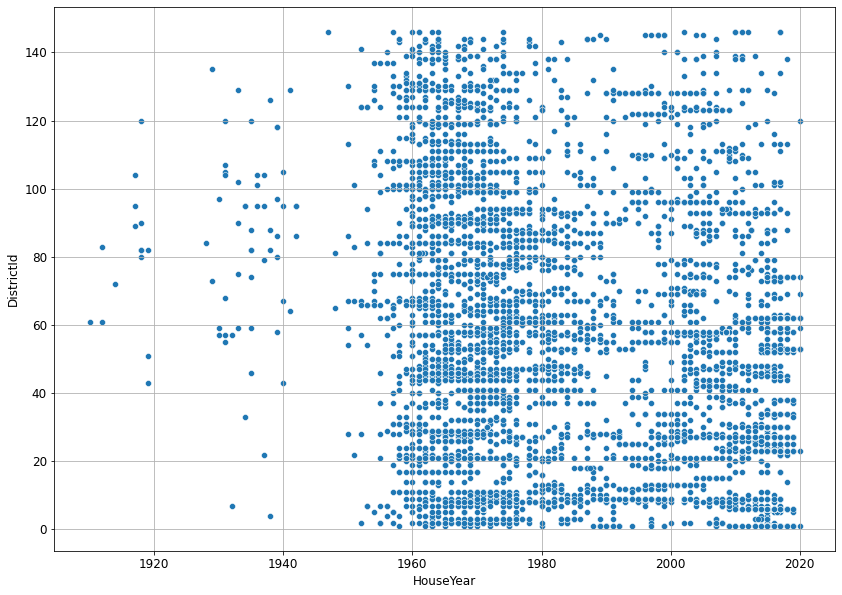

In [14]:
"""plt.figure(figsize = (14,10))
dataindx = (train['Square'] > 27) & (train['HouseYear'] <= 2020) & (train['DistrictId'] >= 1)
sns.scatterplot(x = train.loc[dataindx, 'HouseYear'], y = train.loc[dataindx, 'DistrictId'])
plt.grid(b = True, which = 'both')
plt.minorticks_on
plt.show()"""

In [ ]:
for item in train.columns:
    print(item, ' -- ', 'Unique values:', pd.unique(train[item]), '\n', '\n', pd.value_counts((train[item])), '\n\n\n' )

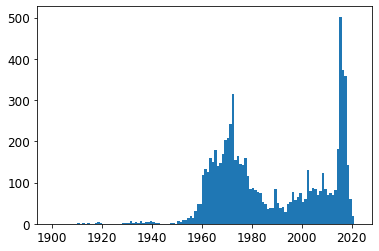

In [16]:
"""plt.hist(train['HouseYear'], bins = 2022-1900, range = (1900,2022), log = False)
plt.show()"""

Checking of empty elements

In [ ]:
train.isnull().sum().sum()

In [ ]:
train.info()

There is plot for price per sq.m from rooms.

In [ ]:
plt.scatter(train['Rooms'], train['Price']/train['Square'])
plt.grid(True)
plt.show()

In [ ]:
bins_num = 15
price_per_area = 10000
fig, axs = plt.subplots(3, 2, figsize=(12, 12), tight_layout=True)
axs[0,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 1) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'orange')
axs[0,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 2) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'yellow')
axs[0,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 3) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'green')
axs[0,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 4) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'grey')
axs[0,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 5) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'blue')
axs[0,0].legend(labels=['Rooms = 1', 'Rooms = 2', 'Rooms = 3', 'Rooms = 4', 'Rooms = 5', 'Rooms = 6'])
axs[0,1].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 1) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'orange')
axs[0,1].axvline((train['Price']/train['Square']).loc[(train['Rooms'] == 1) & ((train['Price']/train['Square']) < price_per_area)].mean(), color='k', linestyle='dashed', linewidth=1)
axs[1,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 2) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'yellow')
axs[1,0].axvline((train['Price']/train['Square']).loc[(train['Rooms'] == 2) & ((train['Price']/train['Square']) < price_per_area)].mean(), color='k', linestyle='dashed', linewidth=1)
axs[1,1].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 3) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'green')
axs[1,1].axvline((train['Price']/train['Square']).loc[(train['Rooms'] == 3) & ((train['Price']/train['Square']) < price_per_area)].mean(), color='k', linestyle='dashed', linewidth=1)
axs[2,0].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 4) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'grey')
axs[2,0].axvline((train['Price']/train['Square']).loc[(train['Rooms'] == 4) & ((train['Price']/train['Square']) < price_per_area)].mean(), color='k', linestyle='dashed', linewidth=1)
axs[2,1].hist((train['Price']/train['Square']).loc[(train['Rooms'] == 5) & ((train['Price']/train['Square']) < price_per_area)], bins = bins_num, density = True, alpha = 0.4, color = 'blue')
axs[2,1].axvline((train['Price']/train['Square']).loc[(train['Rooms'] == 5) & ((train['Price']/train['Square']) < price_per_area)].mean(), color='k', linestyle='dashed', linewidth=1)
axs[0,0].set_xlabel('Price per m^2')
axs[0,1].set_xlabel('Price per m^2')
axs[1,0].set_xlabel('Price per m^2')
axs[1,1].set_xlabel('Price per m^2')
axs[2,0].set_xlabel('Price per m^2')
axs[2,1].set_xlabel('Price per m^2')
axs[0,0].grid(True)
axs[0,1].grid(True)
axs[1,0].grid(True)
axs[1,1].grid(True)
axs[2,0].grid(True)
axs[2,1].grid(True)
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].hist2d(train['Rooms'], train['Price'], bins=(5, 80), norm = colors.LogNorm())
axs[1].hist2d(train['Rooms'], train['Price']/train['Square'], bins=(5, 80), norm = colors.LogNorm())
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('Rooms')
axs[0].set_title('Price')
axs[0].set_ylabel('Price')
axs[1].set_xlabel('Rooms')
axs[1].set_title('Price per square')
axs[1].set_ylabel('Price per m^2')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True, tight_layout=True)
axs[0].hist2d(train['Floor'], train['Price']/train['Square'], bins=(6, 80), norm = colors.LogNorm())
axs[1].hist2d(train['HouseFloor'], train['Price']/train['Square'], bins=(6, 80), norm = colors.LogNorm())
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('Floor')
axs[0].set_title('Price per m^2 from floor')
axs[0].set_ylabel('Price per m^2')
axs[1].set_xlabel('House floor')
axs[1].set_title('Price per square from house floor')
axs[1].set_ylabel('Price per m^2')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].hist2d(train['HouseYear'], train['Price'], bins=(6, 80), norm = colors.LogNorm())
axs[1].hist2d(train['HouseYear'], train['Price']/train['Square'], bins=(6, 80), norm = colors.LogNorm())
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('HouseYear')
axs[0].set_title('Price')
axs[0].set_ylabel('Price')
axs[1].set_xlabel('HouseYear')
axs[1].set_title('Price per square')
axs[1].set_ylabel('Price per m^2')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].hist2d(train['DistrictId'], train['Price'], bins=(6, 80), norm = colors.LogNorm())
axs[1].hist2d(train['DistrictId'], train['Price']/train['Square'], bins=(6, 80), norm = colors.LogNorm())
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('DistrictId')
axs[0].set_title('Price')
axs[0].set_ylabel('Price')
axs[1].set_xlabel('DistrictId')
axs[1].set_title('Price per square')
axs[1].set_ylabel('Price per m^2')
plt.show()

Change Id and DistrictId types to string type.

In [ ]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)

train.select_dtypes(include='object').columns.tolist()

# 2. New numerical features

In [ ]:
str_to_numbers = {'A': 0, 'B': 1}
if train['Ecology_2'].dtype == 'object':
    train['Ecology_2'] = train['Ecology_2'].replace(str_to_numbers)
if train['Ecology_3'].dtype == 'object':
    train['Ecology_3'] = train['Ecology_3'].replace(str_to_numbers)
if train['Shops_2'].dtype == 'object':
    train['Shops_2'] = train['Shops_2'].replace(str_to_numbers)

District is close to the center

In [ ]:
district_location = train.groupby('DistrictId')['HouseYear'].median().reset_index()\
.rename(columns={'index':'DistrictId', 'HouseYear':'DistrictLocation'})
district_location['DistrictLocation'] = district_location['DistrictLocation'].astype(int)
print(district_location)

In [ ]:
plt.hist(district_location['DistrictLocation'], bins = 60)
plt.show()

In [ ]:
train = train.merge(district_location, on='DistrictId', how='left')
train.head()

District have good planting of greenery (lover houses floor - more big trees).

In [ ]:
average_house_floor = train.groupby('DistrictId')['HouseFloor'].median().reset_index()\
.rename(columns={'index':'DistrictId', 'HouseFloor':'AvHouseFloor'})
average_house_floor['AvHouseFloor'] = average_house_floor['AvHouseFloor'].astype(int)
print(average_house_floor)

In [ ]:
plt.hist(average_house_floor['AvHouseFloor'], bins = 60)
plt.show()

In [ ]:
train = train.merge(average_house_floor, on='DistrictId', how='left')
train.head()

In [ ]:
number_of_flats = train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'NumberOfFlats'})
#number_of_flats['NumberOfFlats'] = number_of_flats['NumberOfFlats'].astype(int)
print(number_of_flats)

In [ ]:
train = train.merge(number_of_flats, on='DistrictId', how='left')
train.head()

District have some new houses

In [ ]:
mean_building_year = train.groupby('DistrictId')['HouseYear'].mean().reset_index()\
.rename(columns={'index':'DistrictId', 'HouseYear':'MeanBuildingYear'})
mean_building_year['MeanBuildingYear'] = mean_building_year['MeanBuildingYear'].astype(int)
print(mean_building_year)

In [ ]:
plt.hist(mean_building_year['MeanBuildingYear'], bins = 60)
plt.show()

In [ ]:
train = train.merge(mean_building_year, on='DistrictId', how='left')
train.head()

District population

In [ ]:
district_population = train.groupby('DistrictId')['Rooms'].mean().reset_index()\
.rename(columns={'index':'DistrictId', 'Rooms':'DistrictPopulation'})
number_of_flats = train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'NumberOfFlats'})
district_population = district_population.merge(number_of_flats, on='DistrictId', how='left')
district_population['DistrictAvPopulation'] = district_population["DistrictPopulation"]/district_population["NumberOfFlats"]
district_population = district_population.drop(['NumberOfFlats', 'DistrictPopulation'], axis = 1)
print(district_population)

In [ ]:
plt.hist(district_population['DistrictAvPopulation'], bins = 60)
plt.show()

In [ ]:
train = train.merge(district_population, on='DistrictId', how='left')
train.head()

Average meter price by district

In [ ]:
district_av_meter_price = train.groupby('DistrictId')['Price'].mean().reset_index()\
.rename(columns={'index':'DistrictId'})
district_av_square = train.groupby('DistrictId')['Square'].mean().reset_index()\
                    .rename(columns={'index':'DistrictId'})
district_av_meter_price = district_av_meter_price.merge(district_av_square, on='DistrictId', how='left')
district_av_meter_price['DistrictAvMeterPrice'] = district_av_meter_price["Price"]/district_av_meter_price["Square"]
district_av_meter_price = district_av_meter_price.drop(['Price', 'Square'], axis = 1)
print(district_av_meter_price)

In [ ]:
plt.hist(district_av_meter_price['DistrictAvMeterPrice'], bins = 60)
plt.show()

In [ ]:
train = train.merge(district_av_meter_price, on='DistrictId', how='left')
train.head()

Average price of sq meter for rooms number in district

In [ ]:
train['RoomsMeterPrice'] = train['Price']/train['Square']
rooms_av_meter_price = train.groupby(['DistrictId','Rooms'])['RoomsMeterPrice'].mean().reset_index()\
                    .rename(columns={'index':'Rooms', 'RoomsMeterPrice':'RoomsAvMeterPrice'})
rooms_av_meter_price.head(10)
train = train.drop(columns=['RoomsMeterPrice'])


In [ ]:
train = train.merge(rooms_av_meter_price, how='left')
train.head()

Average price of sq meter for floor number in district

In [ ]:
train['FloorMeterPrice'] = train['Price']/train['Floor']/train['Square']
floor_meter_price = train.groupby(['DistrictId','Floor'])['FloorMeterPrice'].mean().reset_index()\
                    .rename(columns={'index':'Rooms', 'FloorMeterPrice':'FloorAvMeterPrice'})
floor_meter_price.head(20)
#train = train.drop(columns=['RoomsMeterPrice'])

In [ ]:
plt.hist(floor_meter_price['FloorAvMeterPrice'], bins = 60, )
plt.show()

In [ ]:
train = train.merge(floor_meter_price, how = 'left')
train.head()

In [ ]:
train.groupby(round(train['Square']/10))['Price'].mean()

In [ ]:
class FeatureGeneration:
    def __init__(self, Y):
        self.y = Y
        self.square_av_meter_price_df = None
        self.av_meter_price_df = None
        self.district_av_meter_price_df = None
        self.district_house_floor_av_meter_price_df = None
        self.rooms_av_meter_price_df = None
        self.district_rooms_av_meter_price_df = None
        self.district_house_year_rooms_av_meter_price_df = None
        self.district_house_floor_rooms_av_meter_price_df = None
        self.district_kitchen_square_rooms_av_meter_price_df = None
        self.district_life_square_rooms_av_meter_price_df = None
        self.flat_av_meter_price_df = None
        self.floor_meter_price_df = None
        self.district_location_df = None
        self.average_house_floor_df = None
        self.number_of_flats_df = None
        self.mean_building_year_df = None
        self.district_population_df = None
        self.district_planting_of_greenery_df = None
        self.ecology_df = None
        self.district_house_year_kitchen_square_df = None
        self.house_year_rooms_square_df = None
        self.house_year_rooms_life_square_df = None
        self.district_social_df = None
        self.district_healthcare_df = None
        self.district_shops_df = None
        self.house_floor_rooms_square_df = None
        self.house_floor_rooms_life_square_df = None
        

    def add_square_av_meter_price(self, X):
        temp = None
        X['1Square'] = round(X['Square'] / 1)
        if self.square_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['MeterPrice'] = X['Price']/X['Square']
            self.square_av_meter_price_df = X.groupby(['1Square'])['MeterPrice'].mean().reset_index()\
            .rename(columns = {'index':'1Square', 'MeterPrice':'SquareAvMeterPrice'})
            X = X.drop(columns=['MeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.square_av_meter_price_df, on = ['1Square'], how = 'left')
        X = X.drop(columns=['1Square'])
        if (X['SquareAvMeterPrice'].isnull().any()):
            if temp is None:
                temp = X['SquareAvMeterPrice'].median()
            X.loc[X['SquareAvMeterPrice'].isnull(),'SquareAvMeterPrice'] = temp
        return X
    
    def add_av_meter_price(self, X):
        temp = None
        if self.av_meter_price_df is None:
            X['Price'] = self.y.values
            X['MeterPrice'] = X['Price']/X['Square']
            self.av_meter_price_df = X.groupby(['DistrictId'])['MeterPrice'].mean().reset_index()\
            .rename(columns = {'index':'DistrictId', 'MeterPrice':'AvMeterPrice'})
            X = X.drop(columns=['MeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.av_meter_price_df, on = ['DistrictId'], how = 'left')
        if (X['AvMeterPrice'].isnull().any()):
            if temp is None:
                temp = X['AvMeterPrice'].median()
            X.loc[X['AvMeterPrice'].isnull(),'AvMeterPrice'] = temp
        return X
    
    def add_district_av_meter_price(self, X):
        temp = None
        if self.district_av_meter_price_df is None:
            X['Price'] = self.y.values
            self.district_av_meter_price_df = X.groupby('DistrictId')['Price'].mean().reset_index()\
            .rename(columns = {'index':'DistrictId'})
            district_av_square = X.groupby('DistrictId')['Square'].mean().reset_index()\
            .rename(columns = {'index':'DistrictId'})
            self.district_av_meter_price_df = self.district_av_meter_price_df.merge(district_av_square, on = 'DistrictId', how = 'left')
            self.district_av_meter_price_df['DistrictAvMeterPrice'] = self.district_av_meter_price_df["Price"]/self.district_av_meter_price_df["Square"]
            self.district_av_meter_price_df = self.district_av_meter_price_df.drop(['Price', 'Square'], axis = 1)
            X = X.drop(columns=['Price'])
        X = X.merge(self.district_av_meter_price_df, on='DistrictId', how='left')
        if (X['DistrictAvMeterPrice'].isnull().any()):
            if temp is None:
                temp = X['DistrictAvMeterPrice'].median()
            X.loc[X['DistrictAvMeterPrice'].isnull(),'DistrictAvMeterPrice'] = temp
        return X
    
    def add_district_house_floor_av_meter_price(self, X):
        temp = None
        if self.district_house_floor_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['HouseFloorMeterPrice'] = X['Price']/X['HouseFloor']/X['Square']
            self.district_house_floor_av_meter_price_df = X.groupby(['DistrictId', 'HouseFloor'])['HouseFloorMeterPrice'].median().reset_index()\
            .rename(columns = {'index':'DistrictId', 'HouseFloorMeterPrice':'DistrictHouseFloorAvMeterPrice'})
            X = X.drop(columns=['Price'])
            X = X.drop(columns=['HouseFloorMeterPrice'])
        X = X.merge(self.district_house_floor_av_meter_price_df, on = ['DistrictId', 'HouseFloor'], how = 'left')
        if (X['DistrictHouseFloorAvMeterPrice'].isnull().any()):
            if temp is None:
                temp = X['DistrictHouseFloorAvMeterPrice'].median()
            X.loc[X['DistrictHouseFloorAvMeterPrice'].isnull(),'DistrictHouseFloorAvMeterPrice'] = temp
        return X
    
    def add_rooms_av_meter_price(self, X):
        temp = None
        if self.rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.rooms_av_meter_price_df = X.groupby(['Rooms'])['RoomsMeterPrice'].mean().reset_index()\
            .rename(columns={'index':'Rooms', 'RoomsMeterPrice':'RoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.rooms_av_meter_price_df, on=['Rooms'], how='left')
        if (X['RoomsAvMeterPrice'].isnull().any()):
            if temp is None:
                temp = X['RoomsAvMeterPrice'].median()
            X.loc[X['RoomsAvMeterPrice'].isnull(),'RoomsAvMeterPrice'] = temp
        return X
    
    def add_district_rooms_av_meter_price(self, X):
        if self.district_rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.district_rooms_av_meter_price_df = X.groupby(['DistrictId','Rooms'])['RoomsMeterPrice'].median().reset_index()\
            .rename(columns={'index':'Rooms', 'RoomsMeterPrice':'DistrictRoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.district_rooms_av_meter_price_df, on=['DistrictId', 'Rooms'], how='left')
        if (X['DistrictRoomsAvMeterPrice'].isnull().any()):
            X.loc[X['DistrictRoomsAvMeterPrice'].isnull(),'DistrictRoomsAvMeterPrice'] = X.loc[X['DistrictRoomsAvMeterPrice'].isnull(),'RoomsAvMeterPrice']
        return X
    
    def add_district_house_year_rooms_av_meter_price(self, X):
        if self.district_house_year_rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.district_house_year_rooms_av_meter_price_df = X.groupby(['DistrictId','Rooms', 'HouseYear'])['RoomsMeterPrice'].median().reset_index()\
            .rename(columns={'index':'Rooms', 'RoomsMeterPrice':'DistrictHouseYearRoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.district_house_year_rooms_av_meter_price_df, on=['DistrictId','Rooms', 'HouseYear'], how='left')
        if (X['DistrictHouseYearRoomsAvMeterPrice'].isnull().any()):
            X.loc[X['DistrictHouseYearRoomsAvMeterPrice'].isnull(),'DistrictHouseYearRoomsAvMeterPrice'] = X.loc[X['DistrictHouseYearRoomsAvMeterPrice'].isnull(),'DistrictHouseYearRoomsAvMeterPrice'].median()
            X.loc[X['DistrictHouseYearRoomsAvMeterPrice'].isnull(),'DistrictHouseYearRoomsAvMeterPrice'] = X.loc[X['DistrictHouseYearRoomsAvMeterPrice'].isnull(),'DistrictRoomsAvMeterPrice']
        return X
    
    def add_district_house_floor_rooms_av_meter_price(self, X):
        if self.district_house_floor_rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.district_house_floor_rooms_av_meter_price_df = X.groupby(['DistrictId','Rooms', 'HouseFloor'])['RoomsMeterPrice'].median().reset_index()\
            .rename(columns={'index':'Rooms', 'RoomsMeterPrice':'DistrictHouseFloorRoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.district_house_floor_rooms_av_meter_price_df, on=['DistrictId','Rooms', 'HouseFloor'], how='left')
        if (X['DistrictHouseFloorRoomsAvMeterPrice'].isnull().any()):
            X.loc[X['DistrictHouseFloorRoomsAvMeterPrice'].isnull(),'DistrictHouseFloorRoomsAvMeterPrice'] = X.loc[X['DistrictHouseFloorRoomsAvMeterPrice'].isnull(),'DistrictHouseFloorRoomsAvMeterPrice'].median()
            X.loc[X['DistrictHouseFloorRoomsAvMeterPrice'].isnull(),'DistrictHouseFloorRoomsAvMeterPrice'] = X.loc[X['DistrictHouseFloorRoomsAvMeterPrice'].isnull(),'DistrictRoomsAvMeterPrice']
        return X
    
    def add_district_kitchen_square_rooms_av_meter_price(self, X):
        if self.district_kitchen_square_rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.district_kitchen_square_rooms_av_meter_price_df = X.groupby(['DistrictId','Rooms', 'KitchenSquare'])['RoomsMeterPrice'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'RoomsMeterPrice':'DistrictKitchenSquareRoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.district_kitchen_square_rooms_av_meter_price_df, on=['DistrictId','Rooms', 'KitchenSquare'], how='left')
        if (X['DistrictKitchenSquareRoomsAvMeterPrice'].isnull().any()):
            X.loc[X['DistrictKitchenSquareRoomsAvMeterPrice'].isnull(),'DistrictKitchenSquareRoomsAvMeterPrice'] = X['DistrictKitchenSquareRoomsAvMeterPrice'].median()
        return X
    
    def add_district_life_square_rooms_av_meter_price(self, X):
        if self.district_life_square_rooms_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['RoomsMeterPrice'] = X['Price']/X['Square']
            self.district_life_square_rooms_av_meter_price_df = X.groupby(['DistrictId','Rooms', 'LifeSquare'])['RoomsMeterPrice'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'RoomsMeterPrice':'DistrictLifeSquareRoomsAvMeterPrice'})
            X = X.drop(columns=['RoomsMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.district_life_square_rooms_av_meter_price_df, on=['DistrictId','Rooms', 'LifeSquare'], how='left')
        if (X['DistrictLifeSquareRoomsAvMeterPrice'].isnull().any()):
            X.loc[X['DistrictLifeSquareRoomsAvMeterPrice'].isnull(),'DistrictLifeSquareRoomsAvMeterPrice'] = X['DistrictLifeSquareRoomsAvMeterPrice'].median()
        return X
    
    def add_flat_av_meter_price(self, X):
        if self.flat_av_meter_price_df is None:
            X['Price'] = self.y.values
            X['MeterPrice_1'] = X['Price']/X['Square'] # see add_av_meter_price
            self.flat_av_meter_price_df = X.groupby(['DistrictId'])['MeterPrice_1'].mean().reset_index()\
            .rename(columns={'index':'DistrictId', 'MeterPrice_1':'FlatAvMeterPrice'})
            X = X.drop(columns=['MeterPrice_1'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.flat_av_meter_price_df, on=['DistrictId'], how='left')
        if (X['FlatAvMeterPrice'].isnull().any()):
            X.loc[X['FlatAvMeterPrice'].isnull(),'FlatAvMeterPrice'] = X.loc[X['FlatAvMeterPrice'].isnull(),'RoomsAvMeterPrice']
        return X
    
    def add_floor_meter_price(self, X):
        temp = None
        if self.floor_meter_price_df is None:
            X['Price'] = self.y.values
            X['FloorMeterPrice'] = X['Price']/X['Floor']/X['Square']
            self.floor_meter_price_df = X.groupby(['DistrictId','Floor'])['FloorMeterPrice'].mean().reset_index()\
            .rename(columns={'index':'DistrictId', 'FloorMeterPrice':'FloorAvMeterPrice'})
            X = X.drop(columns=['FloorMeterPrice'])
            X = X.drop(columns=['Price'])
        X = X.merge(self.floor_meter_price_df, on=['DistrictId', 'Floor'], how='left')
        if X['FloorAvMeterPrice'].isnull().any():
            if temp is None:
                temp = X['FloorAvMeterPrice'].median()
            X.loc[X['FloorAvMeterPrice'].isnull(),'FloorAvMeterPrice'] = temp
        return X
    
    # ____________________________________________
    
    def add_district_location(self, X):
        temp = None
        if self.district_location_df is None:
            self.district_location_df = X.groupby('DistrictId')['HouseYear'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'HouseYear':'DistrictLocation'})
            self.district_location_df['DistrictLocation'] = self.district_location_df['DistrictLocation'].astype(int)
        X = X.merge(self.district_location_df, on='DistrictId', how='left')
        if (X['DistrictLocation'].isnull().any()):
            if temp is None:
                temp = X['DistrictLocation'].median()
            X.loc[X['DistrictLocation'].isnull(),'DistrictLocation'] = temp
        return X
    
    def add_average_house_floor(self, X):
        temp = None
        if self.average_house_floor_df is None:
            self.average_house_floor_df = X.groupby('DistrictId')['HouseFloor'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'HouseFloor':'AvHouseFloor'})
            self.average_house_floor_df['AvHouseFloor'] = self.average_house_floor_df['AvHouseFloor'].astype(int)
        X = X.merge(self.average_house_floor_df, on='DistrictId', how='left')
        if (X['AvHouseFloor'].isnull().any()):
            if temp is None:
                temp = X['AvHouseFloor'].median()
            X.loc[X['AvHouseFloor'].isnull(),'AvHouseFloor'] = temp
        return X
    
    def add_number_of_flats(self, X):
        temp = None
        if self.number_of_flats_df is None:
            self.number_of_flats_df = X['DistrictId'].value_counts().reset_index()\
            .rename(columns={'index':'DistrictId', 'DistrictId':'NumberOfFlats'})
        X = X.merge(self.number_of_flats_df, on='DistrictId', how='left')
        if (X['NumberOfFlats'].isnull().any()):
            if temp is None:
                temp = X['NumberOfFlats'].median()
            X.loc[X['NumberOfFlats'].isnull(),'NumberOfFlats'] = temp
        return X
    
    def add_mean_building_year(self, X):
        # District have some new houses
        temp = None
        if self.mean_building_year_df is None:
            self.mean_building_year_df = X.groupby('DistrictId')['HouseYear'].mean().reset_index()\
            .rename(columns={'index':'DistrictId', 'HouseYear':'MeanBuildingYear'})
            self.mean_building_year_df['MeanBuildingYear'] = self.mean_building_year_df['MeanBuildingYear'].astype(int)
        X = X.merge(self.mean_building_year_df, on='DistrictId', how='left')
        if (X['MeanBuildingYear'].isnull().any()):
            if temp is None:
                temp = X['MeanBuildingYear'].median()
            X.loc[X['MeanBuildingYear'].isnull(),'MeanBuildingYear'] = temp
        return X
    
    def add_district_population(self, X):
        # The more average rooms in flat the more people could leave in a house. The more sale announcements in district the more population in it.
        temp = None
        if self.district_population_df is None:
            self.district_population_df = X.groupby('DistrictId')['Rooms'].mean().reset_index()\
            .rename(columns={'index':'DistrictId'})
            number_of_flats = X['DistrictId'].value_counts().reset_index()\
            .rename(columns={'index':'DistrictId', 'DistrictId':'NumberOfFlats'})
            self.district_population_df = self.district_population_df.merge(number_of_flats, on='DistrictId', how='left')
            self.district_population_df['DistrictAvPopulation'] = self.district_population_df["NumberOfFlats"] / self.district_population_df["Rooms"]
            self.district_population_df = self.district_population_df.drop(['NumberOfFlats', 'Rooms'], axis = 1)
        X = X.merge(self.district_population_df, on='DistrictId', how='left')
        if (X['DistrictAvPopulation'].isnull().any()):
            if temp is None:
                temp = X['DistrictAvPopulation'].median()
            X.loc[X['DistrictAvPopulation'].isnull(),'DistrictAvPopulation'] = temp
        return X
    
    def add_district_planting_of_greenery(self, X):
        temp = None
        if self.district_planting_of_greenery_df is None:
            self.district_planting_of_greenery_df = X.groupby('DistrictId')['HouseFloor'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'HouseFloor':'Greenery'})
            self.district_planting_of_greenery_df['Greenery'] = self.district_planting_of_greenery_df['Greenery'].astype(int)
        X = X.merge(self.district_planting_of_greenery_df, on='DistrictId', how='left')
        if (X['Greenery'].isnull().any()):
            if temp is None:
                temp = X['Greenery'].median()
            X.loc[X['Greenery'].isnull(),'Greenery'] = temp
        return X
    
    def add_ecology(self, X):
        temp = None
        X['Ecology'] = X['Ecology_1'] / max(X['Ecology_1']) * X['Ecology_2'] / max(X['Ecology_2']) * X['Ecology_3'] / max(X['Ecology_3'])
        if self.ecology_df is None:
            self.ecology_df = X.groupby('DistrictId')['Ecology'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'Ecology':'DistrictAvEcology'})
            #X = X.drop(columns=['Ecology'])
        X = X.merge(self.ecology_df, on = 'DistrictId', how = 'left')
        if (X['DistrictAvEcology'].isnull().any()):
            if temp is None:
                temp = X['DistrictAvEcology'].median()
            X.loc[X['DistrictAvEcology'].isnull(),'DistrictAvEcology'] = temp
        temp = None
        if (X['Ecology'].isnull().any()):
            if temp is None:
                temp = X['Ecology'].median()
            X.loc[X['Ecology'].isnull(),'Ecology'] = temp
        return X
    
    def add_relative_house_floor(self, X):
        temp = None
        X['RelativeHouseFloor'] = X['Floor'] / X['HouseFloor']
        X.loc[X['Floor'] == 1, 'RelativeHouseFloor'] = 0
        return X
    
    def add_district_house_year_kitchen_square(self, X):
        temp = None
        if self.district_house_year_kitchen_square_df is None:
            self.district_house_year_kitchen_square_df = X.groupby(['DistrictId', 'HouseYear'])['KitchenSquare'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'KitchenSquare':'DistrHouseYearKitchenSquare'})
        X = X.merge(self.district_house_year_kitchen_square_df, on = ['DistrictId', 'HouseYear'], how = 'left')
        if (X['DistrHouseYearKitchenSquare'].isnull().any()):
            if temp is None:
                temp = X.groupby('DistrictId')['DistrHouseYearKitchenSquare'].median().reset_index()
            for item in temp['DistrictId']:
                X.loc[(X['DistrHouseYearKitchenSquare'].isnull()) & (X['DistrictId'] == item),'DistrHouseYearKitchenSquare'] = temp.loc[temp['DistrictId'] == item, 'DistrHouseYearKitchenSquare']
            if (X['DistrHouseYearKitchenSquare'].isnull().any()):
                X.loc[(X['DistrHouseYearKitchenSquare'].isnull()),'DistrHouseYearKitchenSquare'] = temp['DistrHouseYearKitchenSquare'].median()
        return X
    
    def add_house_year_rooms_square(self, X):
        temp = None
        X['RoomsSq'] = X['Square'] / X['Rooms']
        if self.house_year_rooms_square_df is None:
            self.house_year_rooms_square_df = X.groupby(['HouseYear', 'Rooms'])['RoomsSq'].median().reset_index()\
            .rename(columns={'index':'HouseYear', 'RoomsSq':'HouseYearAvRoomSquare'})
        X = X.drop(columns=['RoomsSq'])
        X = X.merge(self.house_year_rooms_square_df, on = ['HouseYear', 'Rooms'], how = 'left')
        if (X['HouseYearAvRoomSquare'].isnull().any()):
            if temp is None:
                temp = X.groupby('HouseYear')['HouseYearAvRoomSquare'].median().reset_index()
            for item in temp['HouseYear']:
                X.loc[(X['HouseYearAvRoomSquare'].isnull()) & (X['HouseYear'] == item),'HouseYearAvRoomSquare'] = temp.loc[temp['HouseYear'] == item, 'HouseYearAvRoomSquare']
            if (X['HouseYearAvRoomSquare'].isnull().any()):
                X.loc[(X['HouseYearAvRoomSquare'].isnull()),'HouseYearAvRoomSquare'] = temp['HouseYearAvRoomSquare'].median()
        return X
    
    def add_house_year_rooms_lifesquare(self, X):
        temp = None
        X['RoomsLifeSquare'] = X['LifeSquare'] / X['Rooms']
        if self.house_year_rooms_life_square_df is None:
            self.house_year_rooms_life_square_df = X.groupby(['HouseYear', 'Rooms'])['RoomsLifeSquare'].median().reset_index()\
            .rename(columns={'index':'HouseYear', 'RoomsLifeSquare':'HouseYearAvRoomLifeSquare'})
        X = X.drop(columns=['RoomsLifeSquare'])
        X = X.merge(self.house_year_rooms_life_square_df, on = ['HouseYear', 'Rooms'], how = 'left')
        if (X['HouseYearAvRoomLifeSquare'].isnull().any()):
            if temp is None:
                temp = X.groupby('HouseYear')['HouseYearAvRoomLifeSquare'].median().reset_index()
            for item in temp['HouseYear']:
                X.loc[(X['HouseYearAvRoomLifeSquare'].isnull()) & (X['HouseYear'] == item),'HouseYearAvRoomLifeSquare'] = temp.loc[temp['HouseYear'] == item, 'HouseYearAvRoomLifeSquare']
            if (X['HouseYearAvRoomLifeSquare'].isnull().any()):
                X.loc[(X['HouseYearAvRoomLifeSquare'].isnull()),'HouseYearAvRoomLifeSquare'] = temp['HouseYearAvRoomLifeSquare'].median()
        return X
    
    def add_district_social(self, X):
        temp = None
        X['Social'] = X['Social_1'] / max(X['Social_1']) * X['Social_2'] / max(X['Social_2']) * X['Social_3'] / max(X['Social_3'])
        if self.district_social_df is None:
            self.district_social_df = X.groupby('DistrictId')['Social'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'Social':'DistrictSocial'})
        X = X.drop(columns=['Social'])
        X = X.merge(self.district_social_df, on = 'DistrictId', how = 'left')
        if (X['DistrictSocial'].isnull().any()):
            if temp is None:
                temp = X['DistrictSocial'].median()
                X.loc[(X['DistrictSocial'].isnull()),'DistrictSocial'] = temp
        return X
    
    def add_district_healthcare(self, X):
        temp = None
        X['Healthcare'] = X['Healthcare_1'] / max(X['Healthcare_1']) * X['Helthcare_2'] / max(X['Helthcare_2'])
        if self.district_healthcare_df is None:
            self.district_healthcare_df = X.groupby('DistrictId')['Healthcare'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'Healthcare':'DistrictHealthcare'})
        X = X.drop(columns=['Healthcare'])
        X = X.merge(self.district_healthcare_df, on = 'DistrictId', how = 'left')
        if (X['DistrictSocial'].isnull().any()):
            if temp is None:
                temp = X['DistrictHealthcare'].median()
                X.loc[(X['DistrictHealthcare'].isnull()),'DistrictHealthcare'] = temp
        return X
    
    def add_district_shops(self, X):
        temp = None
        X['Shops'] = X['Shops_1'] / max(X['Shops_1']) * X['Shops_2'] / max(X['Shops_2'])
        if self.district_shops_df is None:
            self.district_shops_df = X.groupby('DistrictId')['Shops'].median().reset_index()\
            .rename(columns={'index':'DistrictId', 'Shops':'DistrictShops'})
        X = X.drop(columns=['Shops'])
        X = X.merge(self.district_shops_df, on = 'DistrictId', how = 'left')
        if (X['DistrictShops'].isnull().any()):
            if temp is None:
                temp = X['DistrictShops'].median()
                X.loc[(X['DistrictShops'].isnull()),'DistrictShops'] = temp
        return X
    
    def add_house_floor_rooms_square(self, X):
        temp = None
        X['RoomsSq'] = X['Square'] / X['Rooms']
        if self.house_floor_rooms_square_df is None:
            self.house_floor_rooms_square_df = X.groupby(['HouseFloor', 'Rooms'])['RoomsSq'].median().reset_index()\
            .rename(columns={'index':'HouseFloor', 'RoomsSq':'HouseFloorAvRoomSquare'})
        X = X.drop(columns=['RoomsSq'])
        X = X.merge(self.house_floor_rooms_square_df, on = ['HouseFloor', 'Rooms'], how = 'left')
        if (X['HouseFloorAvRoomSquare'].isnull().any()):
            if temp is None:
                temp = X.groupby('HouseFloor')['HouseFloorAvRoomSquare'].median().reset_index()
            for item in temp['HouseFloor']:
                wrongdataindx = ((X['HouseFloorAvRoomSquare'].isnull()) & (X['HouseFloor'] == item))
                X.loc[wrongdataindx,'HouseFloorAvRoomSquare'] = temp.loc[temp['HouseFloor'] == item, 'HouseFloorAvRoomSquare']
            if (X['HouseFloorAvRoomSquare'].isnull().any()):
                X.loc[(X['HouseFloorAvRoomSquare'].isnull()),'HouseFloorAvRoomSquare'] = temp['HouseFloorAvRoomSquare'].median()
        return X
    
    def add_house_floor_rooms_lifesquare(self, X):
        temp = None
        X['RoomsLifeSquare'] = X['LifeSquare'] / X['Rooms']
        if self.house_floor_rooms_life_square_df is None:
            self.house_floor_rooms_life_square_df = X.groupby(['HouseFloor', 'Rooms'])['RoomsLifeSquare'].median().reset_index()\
            .rename(columns={'index':'HouseFloor', 'RoomsLifeSquare':'HouseFloorAvRoomLifeSquare'})
        X = X.drop(columns=['RoomsLifeSquare'])
        X = X.merge(self.house_floor_rooms_life_square_df, on = ['HouseFloor', 'Rooms'], how = 'left')
        if (X['HouseFloorAvRoomLifeSquare'].isnull().any()):
            if temp is None:
                temp = X.groupby('HouseFloor')['HouseFloorAvRoomLifeSquare'].median().reset_index()
            for item in temp['HouseFloor']:
                X.loc[(X['HouseFloorAvRoomLifeSquare'].isnull()) & (X['HouseFloor'] == item),'HouseFloorAvRoomLifeSquare'] = temp.loc[temp['HouseFloor'] == item, 'HouseFloorAvRoomLifeSquare']
            if (X['HouseFloorAvRoomLifeSquare'].isnull().any()):
                X.loc[(X['HouseFloorAvRoomLifeSquare'].isnull()),'HouseFloorAvRoomLifeSquare'] = temp['HouseFloorAvRoomLifeSquare'].median()
        return X
    
    def add_ideal_data(self, X):
        temp = None
        X['IdealData'] = X['WrongRoom'] + X['WrongSquare'] + X['WrongLifeSquare'] + X['WrongKitchenSquare'] + X['WrongHouseFloor'] + X['WrongFloor'] + X['WrongHouseYear'] + X['SingleRoom'] + X['WrongDistr']
        return X
    
    def add_new_features(self, X):
        if (self.y is not None):
            X = self.add_square_av_meter_price(X)
            X = self.add_av_meter_price(X)
            X = self.add_district_av_meter_price(X)
            X = self.add_district_house_floor_av_meter_price(X)
            X = self.add_rooms_av_meter_price(X)
            X = self.add_district_rooms_av_meter_price(X)
            X = self.add_district_house_year_rooms_av_meter_price(X)
            X = self.add_district_house_floor_rooms_av_meter_price(X)
            X = self.add_district_kitchen_square_rooms_av_meter_price(X)
            X = self.add_district_life_square_rooms_av_meter_price(X)
            X = self.add_flat_av_meter_price(X)
            X = self.add_floor_meter_price(X)
        X = self.add_district_location(X)
        X = self.add_average_house_floor(X)
        X = self.add_number_of_flats(X)
        X = self.add_mean_building_year(X)
        X = self.add_district_population(X)
        X = self.add_district_planting_of_greenery(X)
        X = self.add_ecology(X)
        X = self.add_relative_house_floor(X)
        X = self.add_district_house_year_kitchen_square(X)
        X = self.add_house_year_rooms_square(X)
        X = self.add_house_year_rooms_lifesquare(X)
        X = self.add_district_social(X)
        X = self.add_district_healthcare(X)
        X = self.add_district_shops(X)
        X = self.add_house_floor_rooms_square(X)
        X = self.add_house_floor_rooms_lifesquare(X)
        X = self.add_ideal_data(X)
        return X

# 3. Features selection

In [ ]:
train.columns.tolist()

In [ ]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2', 'WrongSquare', 'WrongLifeSquare',
                 'WrongKitchenSquare', 'WrongHouseFloor', 'WrongFloor', 'WrongHouseYear', 'WrongDistr']

new_feature_names = ['SquareAvMeterPrice','AvMeterPrice','DistrictAvMeterPrice', 'DistrictHouseFloorAvMeterPrice', 
                    'RoomsAvMeterPrice', 
                     'DistrictRoomsAvMeterPrice', 'DistrictHouseYearRoomsAvMeterPrice', 
                     'DistrictHouseFloorRoomsAvMeterPrice', 'DistrictKitchenSquareRoomsAvMeterPrice',
                     'DistrictLifeSquareRoomsAvMeterPrice', 'FlatAvMeterPrice', 
                     'FloorAvMeterPrice', 'DistrictLocation', 'AvHouseFloor', 'NumberOfFlats', 'MeanBuildingYear', 
                     'DistrictAvPopulation', 'Greenery', 'Ecology', 'DistrictAvEcology', 'RelativeHouseFloor', 
                     'DistrHouseYearKitchenSquare', 'HouseYearAvRoomSquare', 'HouseYearAvRoomLifeSquare', 
                     'DistrictSocial', 'DistrictHealthcare', 'DistrictShops', 'HouseFloorAvRoomSquare', 
                     'HouseFloorAvRoomLifeSquare', 'IdealData']

# full dataset
"""feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2', 'WrongRoom', 'WrongSquare', 'WrongLifeSquare',
                 'WrongKitchenSquare', 'WrongHouseFloor', 'WrongFloor', 'WrongHouseYear', 'SingleRoom', 'WrongDistr']
new_feature_names = ['SquareAvMeterPrice','AvMeterPrice','DistrictAvMeterPrice', 'DistrictHouseFloorAvMeterPrice', 
                    'RoomsAvMeterPrice', 
                     'DistrictRoomsAvMeterPrice', 'DistrictHouseYearRoomsAvMeterPrice', 
                     'DistrictHouseFloorRoomsAvMeterPrice', 'DistrictKitchenSquareRoomsAvMeterPrice',
                     'DistrictLifeSquareRoomsAvMeterPrice', 'FlatAvMeterPrice', 
                     'FloorAvMeterPrice', 'DistrictLocation', 'AvHouseFloor', 'NumberOfFlats', 'MeanBuildingYear', 
                     'DistrictAvPopulation', 'Greenery', 'Ecology', 'DistrictAvEcology', 'RelativeHouseFloor', 
                     'DistrHouseYearKitchenSquare', 'HouseYearAvRoomSquare', 'HouseYearAvRoomLifeSquare', 
                     'DistrictSocial', 'DistrictHealthcare', 'DistrictShops', 'HouseFloorAvRoomSquare', 
                     'HouseFloorAvRoomLifeSquare', 'IdealData'] """
target_name = 'Price'


# 4. Train and set subdivision

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
X = train.drop(columns = target_name)
y = train[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, shuffle = True, random_state = 21)
#print(X_train.shape, X_valid.shape, test.shape)

In [ ]:
preprocessor = DataPreprocessing()
X_train = preprocessor.data_correction(X_train)
X_valid = preprocessor.data_correction(X_valid)
test = preprocessor.data_correction(test)
#print(X_train.shape, X_valid.shape, test.shape)

# 5. New features add to train and test

In [ ]:
newfeatures = FeatureGeneration(y_train)
print(X_train.columns.tolist())

In [ ]:
#X_train.head()

In [ ]:
X_train = newfeatures.add_new_features(X_train)
X_valid = newfeatures.add_new_features(X_valid)
valid = X_valid.copy()
test = newfeatures.add_new_features(test)
X_train_initial, X_valid_initial, y_train_initial, y_valid_initial = X_train, X_valid, y_train, y_valid
test_initial = test
#X_train.shape, X_valid.shape, test.shape

In [ ]:
X_train = X_train_initial[feature_names + new_feature_names]
X_valid = X_valid_initial[feature_names + new_feature_names]
test = test_initial[feature_names + new_feature_names]
#X_train.shape, X_valid.shape, test.shape

Check NaN values through all datasets

In [ ]:
X_train.isnull().sum().sum(), X_valid.isnull().sum().sum(), y_train.isnull().sum()

In [ ]:
#X_train.dtypes
#X_train.head()

In [ ]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Validation R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    plt.figure(figsize = (18,10))
    plt.subplot(121)
    sns.scatterplot(x = train_pred_values, y = train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    plt.subplot(122)
    sns.scatterplot(x = test_pred_values, y = test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Validation sample prediction')
    plt.show()

# Random Forest Regressor

In [ ]:
### rf_model = RandomForestRegressor(random_state = 21, criterion = 'mse')
#n_estimators=100, *, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None
rf_model = RandomForestRegressor(random_state = 21, n_estimators=300, criterion = 'mse', min_samples_leaf=3,
                                 min_weight_fraction_leaf = 0.0005)
rf_model.fit(X_train, y_train)

Check NaN values through all dataset

In [ ]:
#X_valid.isnull().sum().sum()

In [ ]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)
y_test_preds_rf = y_test_preds.copy()
rf_model.score(X_valid, y_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
cv_score = cross_val_score(rf_model, X_valid, y_valid, scoring = 'r2', cv = KFold(n_splits = 3, shuffle = True, random_state = 21))
cv_score

In [ ]:
0.922 #0.7593 random_state = 21, n_estimators=500, criterion = 'mse', max_depth = 14, min_samples_split=4, min_samples_leaf=3, min_weight_fraction_leaf = 0.00012
0.927 #0.7594 random_state = 21, n_estimators=500, criterion = 'mse', max_depth = 16, min_samples_split=3, min_samples_leaf=3, min_weight_fraction_leaf = 0.0001
0.927 #0.7594 random_state = 21, n_estimators=500, criterion = 'mse', max_depth = 16, min_samples_split=3, min_samples_leaf=3, min_weight_fraction_leaf = 0.00005
0.911 #0.757 random_state = 21, n_estimators=600, criterion = 'mse', max_depth = 16, min_samples_split=3, min_samples_leaf=4, min_weight_fraction_leaf = 0.0001
0.945 #0.7600 random_state = 21, n_estimators=600, criterion = 'mse', max_depth = 16, min_samples_split=2, min_samples_leaf=2, min_weight_fraction_leaf = 0.0001
0.945 #0.760 random_state = 21, n_estimators=600, criterion = 'mse', max_depth = 16, min_samples_split=2, min_samples_leaf=2, min_weight_fraction_leaf = 0.0001
0.946 #0.7595 random_state = 21, n_estimators=600, criterion = 'mse', max_depth = 16, min_samples_split=3, min_samples_leaf=2, min_weight_fraction_leaf = 0.0001
0.923 #0.7590 random_state = 21, n_estimators=600, criterion = 'mse', max_depth = 12, min_samples_split=3, min_samples_leaf=2, min_weight_fraction_leaf = 0.0001
0.939 #0.7598 random_state = 21, n_estimators=600, criterion = 'mse', max_depth = 14, min_samples_split=3, min_samples_leaf=2, min_weight_fraction_leaf = 0.0001
0.939 #0.7613 random_state = 21, n_estimators=600, criterion = 'mse', max_depth = 14, min_samples_split=3, min_samples_leaf=2, min_weight_fraction_leaf = 0.0001
0.939 #0.7615 random_state = 21, n_estimators=600, criterion = 'mse', max_depth = 15, min_samples_split=3, min_samples_leaf=2, min_weight_fraction_leaf = 0.0001
0.929 #0.7600 random_state = 21, n_estimators=600, criterion = 'mse', max_depth = 16, min_samples_split=3, min_samples_leaf=3, min_weight_fraction_leaf = 0.00005
cv_score.mean()

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns = ['feature_name', 'importance'])

feature_importances.sort_values(by = 'importance', ascending = False)

# Gradient Boosting Regressor

In [ ]:
"""(*, loss='ls', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', 
min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, 
warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)"""
gb_model = GradientBoostingRegressor(loss='ls', learning_rate=0.01, n_estimators=300, subsample=1.0, 
                                     min_weight_fraction_leaf=0.0005, max_depth=12, max_features=18, random_state=21)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)
y_test_preds_gb = y_test_preds.copy()

gb_model.score(X_valid, y_valid)

In [ ]:
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
cv_score = cross_val_score(gb_model, X_valid, y_valid, scoring = 'r2', cv = KFold(n_splits = 3, shuffle = True, random_state = 21))
print(cv_score)
0.7590 # loss='huber', learning_rate=0.02, n_estimators=500, subsample=1.0, min_samples_split=3, min_samples_leaf=5, min_weight_fraction_leaf=0.0001, max_depth=15, random_state=21, max_features=30
0.976  # 0.7638 loss='huber', learning_rate=0.02, n_estimators=600, subsample=1.0, min_samples_split=5, min_samples_leaf=7, min_weight_fraction_leaf=0.0001, max_depth=15, random_state=21, max_features=30
0.968 # 0.7635 loss='huber', learning_rate=0.023, n_estimators=300, subsample=1.0, min_samples_split=6, min_samples_leaf=8, min_weight_fraction_leaf=0.0001, max_depth=15, random_state=21, max_features=30
0.969 # 0.7536 loss='huber', learning_rate=0.023, n_estimators=300, subsample=1.0, min_samples_split=6, min_samples_leaf=8, min_weight_fraction_leaf=0.0001, max_depth=15, random_state=21, max_features=40
0.969 # 0.7616 loss='huber', learning_rate=0.023, n_estimators=300, subsample=1.0, min_samples_split=6, min_samples_leaf=8, min_weight_fraction_leaf=0.0001, max_depth=15, random_state=21, max_features=35
0.97 #0.7503 loss='huber', learning_rate=0.025, n_estimators=300, subsample=1.0, min_samples_split=6, min_samples_leaf=8, min_weight_fraction_leaf=0.00005, max_depth=16, random_state=21
0.969 #0.7685 loss='huber', learning_rate=0.025, n_estimators=300, subsample=1.0, min_samples_split=6, min_samples_leaf=8, min_weight_fraction_leaf=0.00005, max_depth=16, random_state=21, max_features=20
0.968 # 0.7690 loss='huber', learning_rate=0.025, n_estimators=300, subsample=1.0, min_samples_split=6, min_samples_leaf=8, min_weight_fraction_leaf=0.00005, max_depth=16, random_state=21, max_features=15
0.968 # 0.7690 loss='huber', learning_rate=0.025, n_estimators=300, subsample=1.0, min_samples_split=6, min_samples_leaf=8, min_weight_fraction_leaf=0.00005, max_depth=16, random_state=21, max_features=20
0.971 #0.7674 loss='huber', learning_rate=0.025, n_estimators=300, subsample=1.0, min_samples_split=6, min_samples_leaf=8, min_weight_fraction_leaf=0.00005, max_depth=16, random_state=21, max_features=20
0.976 #0.7659 loss='huber', learning_rate=0.025, n_estimators=300, subsample=1.0, min_samples_split=4, min_samples_leaf=5, min_weight_fraction_leaf=0.0001, max_depth=12, random_state=21, max_features=15
0.982 #0.7617 loss='huber', learning_rate=0.025, n_estimators=300, subsample=1.0, min_samples_split=4, min_samples_leaf=5, min_weight_fraction_leaf=0.00005, max_depth=14, random_state=21, max_features=15
0.984 #0.7643 loss='huber', learning_rate=0.025, n_estimators=300, subsample=1.0, min_samples_split=4, min_samples_leaf=5, min_weight_fraction_leaf=0.00005, max_depth=14, random_state=21, max_features=15
0.975 #0.7729 loss='huber', learning_rate=0.023, n_estimators=400, subsample=1.0, min_samples_split=6, min_samples_leaf=8, min_weight_fraction_leaf=0.00005, max_depth=16, random_state=21, max_features=22

cv_score.mean()


In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns = ['feature_name', 'importance'])
feature_importances.sort_values(by = 'importance', ascending = False)

# BaggingRegressor

In [ ]:
"""(base_estimator=None, n_estimators=10, *, max_samples=1.0, max_features=1.0, bootstrap=True, 
bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)"""
bagg_model = BaggingRegressor(n_estimators = 300 , random_state = 21)
bagg_model.fit(X_train, y_train)

y_train_preds = bagg_model.predict(X_train)
y_test_preds = bagg_model.predict(X_valid)
y_test_preds_bagg = y_test_preds.copy()

bagg_model.score(X_valid, y_valid)

In [ ]:
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
cv_score = cross_val_score(bagg_model, X_valid, y_valid, scoring = 'r2', cv = KFold(n_splits = 3, shuffle = True, random_state = 21))
print(cv_score)
cv_score.mean()

# HistGradientBoostingRegressor

In [ ]:
"""(loss='least_squares', *, learning_rate=0.1, max_iter=100, max_leaf_nodes=31, max_depth=None, 
min_samples_leaf=20, l2_regularization=0.0, max_bins=255, categorical_features=None, monotonic_cst=None, 
warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, 
verbose=0, random_state=None)"""
histgb_model = HistGradientBoostingRegressor(loss='least_squares', max_iter = 300,max_leaf_nodes=30, 
                                             max_depth=16, min_samples_leaf=5, random_state=21)
histgb_model.fit(X_train, y_train)

y_train_preds = histgb_model.predict(X_train)
y_test_preds = histgb_model.predict(X_valid)
y_test_preds_histgb = y_test_preds.copy()

histgb_model.score(X_valid, y_valid)

In [ ]:
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
cv_score = cross_val_score(bagg_model, X_valid, y_valid, scoring = 'r2', cv = KFold(n_splits = 3, shuffle = True, random_state = 21))
print(cv_score)
cv_score.mean()

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns = ['feature_name', 'importance'])
feature_importances.sort_values(by = 'importance', ascending = False)

# Voting Regressor

In [ ]:
votingregr = VotingRegressor([('rf_model', rf_model), ('gb_model', gb_model), ('bagg_model', bagg_model), ('histgb_model', histgb_model)], n_jobs = -1)
votingregr.fit(X_train, y_train)
y_train_preds = votingregr.predict(X_train)
y_test_preds = votingregr.predict(X_valid)
y_test_preds_vr = y_test_preds.copy()

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [ ]:
cv_score = cross_val_score(votingregr, X_valid, y_valid, scoring = 'r2', cv = KFold(n_splits = 3, shuffle = True, random_state = 21))
print(cv_score)
cv_score.mean()

In [ ]:
X_valid.head(5)
valid
temp

In [ ]:
#y_test_preds_vr
y_test_preds_bagg
y_test_preds_gb
y_test_preds_rf
frame = { 'Price': y_valid_initial, 'PredPrice': y_test_preds_rf } 
temp = pd.DataFrame(frame)
temp['WrongPrice'] = 0.0
temp.loc[(abs(temp['Price'] - temp['PredPrice'])/temp['Price'])>0.1,'WrongPrice'] = 1
#print(temp.columns.tolist())
valid['Price'] = y_valid_initial.values

In [ ]:
valid.isnull().sum().sum()

In [ ]:
plt.figure(figsize = (9,10))
sns.scatterplot(x = temp.loc[temp['WrongPrice'] == 1, 'Price'], y = temp.loc[temp['WrongPrice'] == 1, 'PredPrice'])
temp.columns.tolist()

In [ ]:
#columns1 = ['Id','DistrictId', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
#                 'IdealData', 'WrongHouseYear' , 'WrongHouseFloor' , 'WrongFloor' , 'WrongRoom' , 'WrongSquare' , 'WrongLifeSquare' , 'WrongKitchenSquare']
if 'PredPrice' in valid.columns:
    valid = valid.drop(columns=['PredPrice', 'WrongPrice'])
    
valid = valid.merge(temp, on = 'Price',how = 'left')
valid.columns.tolist()
#valid.loc[valid['Price'] != 1, columns1]

In [ ]:
hyear = 1977
for numrooms in range(1,7):
    corrDataIdx = ((valid['Rooms'] == numrooms) & (valid['HouseYear'] == hyear))
    squarediff = valid.loc[corrDataIdx, 'Square']
    
    print(squarediff.min(), squarediff.median(), squarediff.max())
    
for numrooms in range(1,7):
    corrDataIdx = ((valid['Rooms'] == numrooms) & (valid['HouseYear'] == hyear))
    squarediff = valid.loc[corrDataIdx, 'LifeSquare']
    
    print(squarediff.min(), squarediff.median(), squarediff.max())
    
for numrooms in range(1,7):
    corrDataIdx = ((valid['Rooms'] == numrooms) & (valid['HouseYear'] == hyear))
    squarediff = valid.loc[corrDataIdx, 'Square'] - valid.loc[corrDataIdx, 'LifeSquare']
    
    print(squarediff.min(), squarediff.median(), squarediff.max())
    
for numrooms in range(1,7):
    corrDataIdx = ((valid['Rooms'] == numrooms) & (valid['HouseYear'] == hyear))
    squarediff = valid.loc[corrDataIdx, 'Square'] - valid.loc[corrDataIdx, 'LifeSquare'] - valid.loc[corrDataIdx, 'KitchenSquare']
    
    print(squarediff.min(), squarediff.median(), squarediff.max())

In [ ]:
for num in range(1900,2021): 
    hyear = valid.loc[(valid['HouseYear'] == num) & (valid['WrongPrice'] == 1), ['HouseYear','HouseFloor']]

valid.loc[valid['WrongPrice'] == 1].groupby('HouseYear')['HouseFloor'].count()

print(valid.loc[valid['WrongPrice'] == 1].groupby(['HouseYear','HouseFloor', 'Floor', 'IdealData'])['HouseFloor'].count())


In [ ]:
print(valid.groupby(['HouseYear','HouseFloor', 'IdealData', 'WrongHouseYear' , 'WrongHouseFloor' , 'WrongFloor' , 'WrongRoom' , 'WrongKitchenSquare'])['HouseFloor'].count())

In [ ]:
columns1 = ['DistrictId', 'Square', 'Rooms', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                  'Shops_1', 'Price', 'PredPrice', 'WrongPrice', 'IdealData']
print('overall wrong price: ', valid.loc[(valid['WrongPrice'] == 1), 'DistrictId'].count())
print('corrected data', '\n',valid.loc[(valid['WrongPrice'] == 1) & (valid['IdealData'] != 0), 'HouseYear'].count())
print('WrongHouseYear ', '\n', valid.loc[(valid['WrongPrice'] == 1) & (valid['WrongHouseYear'] != 0), 'HouseYear'].count())
print('WrongHouseFloor ', '\n', valid.loc[(valid['WrongPrice'] == 1) & (valid['WrongHouseFloor'] != 0), 'HouseYear'].count())
print('WrongFloor ', '\n', valid.loc[(valid['WrongPrice'] == 1) & (valid['WrongFloor'] != 0), 'HouseYear'].count())
print('WrongRoom ', '\n', valid.loc[(valid['WrongPrice'] == 1) & (valid['WrongRoom'] != 0), 'HouseYear'].count())
print('WrongKitchenSquare ', '\n', valid.loc[(valid['WrongPrice'] == 1) & (valid['WrongKitchenSquare'] != 0), 'HouseYear'].count())
print('WrongSquare ', '\n', valid.loc[(valid['WrongPrice'] == 1) & (valid['WrongSquare'] != 0), 'HouseYear'].count())
print('WrongLifeSquare ', '\n', valid.loc[(valid['WrongPrice'] == 1) & (valid['WrongLifeSquare'] != 0), 'HouseYear'].count())
print('overall correct price: ', valid.loc[(valid['WrongPrice'] != 1), 'DistrictId'].count())
print('corrected data', '\n',valid.loc[(valid['WrongPrice'] != 1) & (valid['IdealData'] != 0), 'HouseYear'].count())
print('WrongHouseYear ', '\n', valid.loc[(valid['WrongPrice'] != 1) & (valid['WrongHouseYear'] != 0), 'HouseYear'].count())
print('WrongHouseFloor ', '\n', valid.loc[(valid['WrongPrice'] != 1) & (valid['WrongHouseFloor'] != 0), 'HouseYear'].count())
print('WrongFloor ', '\n', valid.loc[(valid['WrongPrice'] != 1) & (valid['WrongFloor'] != 0), 'HouseYear'].count())
print('WrongRoom ', '\n', valid.loc[(valid['WrongPrice'] != 1) & (valid['WrongRoom'] != 0), 'HouseYear'].count())
print('WrongKitchenSquare ', '\n', valid.loc[(valid['WrongPrice'] != 1) & (valid['WrongKitchenSquare'] != 0), 'HouseYear'].count())
print('WrongSquare ', '\n', valid.loc[(valid['WrongPrice'] != 1) & (valid['WrongSquare'] != 0), 'HouseYear'].count())
print('WrongLifeSquare ', '\n', valid.loc[(valid['WrongPrice'] != 1) & (valid['WrongLifeSquare'] != 0), 'HouseYear'].count())


print(valid.loc[(valid['WrongPrice'] == 1) & (valid['LifeSquare'] <= 90), 'DistrictId'].count())

print(valid.loc[(valid['WrongPrice'] == 1) & (valid['WrongHouseFloor'] == 0), 'DistrictId'].count(), valid.loc[valid['WrongFloor'] == 0, 'DistrictId'].count())
print(valid.loc[(valid['WrongPrice'] == 1) & (valid['HouseYear'] == 1977), 'DistrictId'].count(), valid.loc[(valid['WrongPrice'] != 1) & (valid['HouseYear'] == 1977), 'DistrictId'].count())
print(valid.loc[(valid['WrongPrice'] == 1) & (valid['HouseYear'] == 1989), 'DistrictId'].count(), valid.loc[(valid['WrongPrice'] != 1) & (valid['HouseYear'] == 1989), 'DistrictId'].count())

valid.loc[(valid['WrongPrice'] != 0)].head(10)
plt.hist(valid.loc[(valid['WrongPrice'] != 0), 'HouseYear'], bins = 2020-1955, range = (1955, 2020))
plt.show()
plt.hist(valid.loc[(valid['WrongPrice'] != 0), 'Floor'], bins = 18-1, range = (1, 18))
plt.show()
plt.hist(valid.loc[(valid['WrongPrice'] != 0), 'HouseFloor'], bins = 20-5, range = (5, 20))
plt.show()
plt.hist(valid.loc[(valid['WrongPrice'] != 0), 'LifeSquare'], bins = 70-1, range = (1, 70))
plt.show()
plt.hist(valid.loc[(valid['WrongPrice'] != 0), 'Square'], bins = 100-20, range = (20, 100))
plt.show()
plt.hist(valid.loc[(valid['WrongPrice'] != 0), 'KitchenSquare'], bins = 15-5, range = (5, 15))
plt.show()
plt.hist(valid.loc[(valid['WrongPrice'] != 0), 'Rooms'], bins = 6-1, range = (1, 6))
plt.show()

plt.figure(figsize = (14,10))
sns.scatterplot(x = valid.loc[(valid['WrongPrice'] == 1) & (valid['IdealData'] != 0), 'HouseYear'], y = valid.loc[(valid['WrongPrice'] == 1) & (valid['IdealData'] != 0), 'DistrictId'])
plt.grid(b = True, which = 'both')
plt.minorticks_on
plt.show()

print(valid.loc[(valid['WrongPrice'] == 1) & (valid['HouseYear'] == 1977) & (valid['IdealData'] != 0) , columns1])

## StackingRegressor

In [ ]:
estimators = [('rf_model', rf_model), ('gb_model', gb_model), ('bagg_model', bagg_model), ('histgb_model', histgb_model)]

In [ ]:
"""stack_model = StackingRegressor(estimators=estimators)
stack_model.fit(X_train, y_train)
y_train_preds = stack_model.predict(X_train)
y_test_preds = stack_model.predict(X_valid)
stack_model.score(X_valid, y_valid)"""

In [ ]:
"""evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)"""

In [ ]:
"""cv_score = cross_val_score(votingregr, X_valid, y_valid, scoring = 'r2', cv = KFold(n_splits = 3, shuffle = True, random_state = 21))
print(cv_score)
cv_score.mean()"""